In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import array
import math
from scipy import signal

signal generation

In [2]:
sig1 = array.array('f')
sig2 = array.array('f')
for i in range(0,25000000):
    a = 10
    b = 10
    rand1 = random.randint(0,3)
    rand2 = random.randint(0,3)
    for j in range(0,a):
        sig1.append(rand1)
    for k in range(0,b):
        sig2.append(rand2)

length1 = len(sig1)
length2 = len(sig2)
print(length1)
print(length2)
if length1 > length2:
    length = length2
else:
    length = length1
print(length)

250000000
250000000
250000000


Lowpass filtering

In [4]:
b,a = signal.butter(2,0.16,'lowpass')
y1 = signal.filtfilt(b,a,sig1)
y2 = signal.filtfilt(b,a,sig2)

eye diagram of the original data

 <span style="color:red"> comments (crh:) your data rate looks like 3.3 Gbaud/s. Can you make it 32G?  </span>



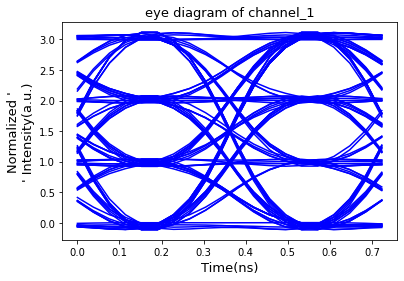

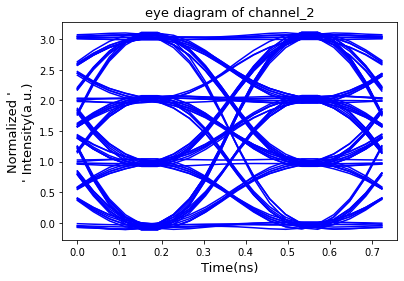

In [52]:
x = np.linspace(0,19,500)
xx = np.linspace(1,length,length)
for i in range(100):
    y=[]
    for j in range(20):
        y.append(y1[(i+10)*20+j])
    plt.plot(x[:20],y,'b')
plt.xlabel("Time(ns)",fontsize=13)
plt.ylabel("Normalized '\n' Intensity(a.u.)",fontsize=13)
plt.title('eye diagram of channel_1',fontsize=13)
plt.show()
for i in range(100):
    y=[]
    for j in range(20):
        y.append(y2[(i+10)*20+j])
    plt.plot(x[:20],y,'b')
plt.xlabel("Time(ns)",fontsize=13)
plt.ylabel("Normalized '\n' Intensity(a.u.)",fontsize=13)
plt.title('eye diagram of channel_2',fontsize=13)
plt.show()

original waveform

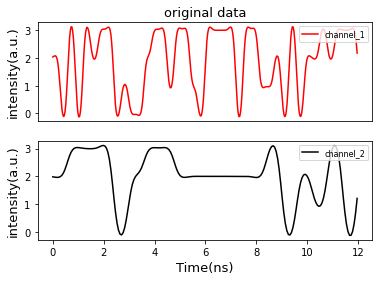

In [7]:
plt.subplot(2,1,1)
plt.plot(x[:400],y1[:400],'r')
plt.ylabel("intensity(a.u.)",fontsize = 13)
plt.legend(["channel_1"],fontsize=8,loc=1)
plt.title("original data",fontsize=13)
plt.xticks([])

plt.subplot(2,1,2)
plt.plot(x[:200],y2[:200],'k')
plt.xlabel("Time(ns)",fontsize=13)
plt.ylabel("intensity(a.u.)",fontsize=13)
plt.legend(["channel_2"],fontsize=8,loc = 1)
plt.show()

transmission matrix

In [9]:
a = 0.87
b = 0.15
c = 0.13
d = 0.85

In [10]:
Y3=[]
Y4=[]
for i in range(0,length//200):
    Y3.append((a+0.005*math.sin(xx[i]*math.pi/1000))*y1[200*i]+(b+0.005*math.cos(xx[i]*math.pi/1000))*y2[200*i])
    Y4.append((c-0.005*math.cos(xx[i]*math.pi/1000))*y1[200*i]+(d-0.005*math.sin(xx[i]*math.pi/1000))*y2[200*i])


set bytes in a group

In [53]:
count = 0
groupnumber = 1500

function of variance and kurtosis

In [54]:
def f_vork(W_1,W_2,m1,channel,y3=Y3,y4=Y4):
    global count
    global groupnumber
    count = count + 1
    if m1 == 1:
        W_1 = 0.8 + 0.2 * W_1
        W_2 = -abs(0.2 * W_2)
        to = [W_1*j+W_2*k for j,k in zip(y3[groupnumber*(count-1):groupnumber*count], y4[groupnumber*(count-1):groupnumber*count])]
        return np.var(to)
    elif m1 == 2:
        W_1_array = np.array(W_1)
        W_2_array = np.array(W_2)
        v = copy()
        WV1 = v[0]*W_1_array + v[1]*W_2_array
        WV2 = v[2]*W_1_array + v[3]*W_2_array
        if channel == 1:
            WV1 = round(0.8 + 0.2 * (v[0]*W_1_array + v[1]*W_2_array)/(abs(v[0]*W_1_array + v[1]*W_2_array)+abs(v[2]*W_1_array + v[3]*W_2_array)),3)
            WV2 = round(-abs(0.2 * (v[2]*W_1_array + v[3]*W_2_array)/(abs(v[0]*W_1_array + v[1]*W_2_array)+abs(v[2]*W_1_array + v[3]*W_2_array))),3)
        if channel == 2:
            WV1 = round(-abs(0.2 * (v[0]*W_1_array + v[1]*W_2_array)/(abs(v[0]*W_1_array + v[1]*W_2_array)+abs(v[2]*W_1_array + v[3]*W_2_array))),3)
            WV2 = round(0.8 + 0.2 * (v[2]*W_1_array + v[3]*W_2_array)/(abs(v[0]*W_1_array + v[1]*W_2_array)+abs(v[2]*W_1_array + v[3]*W_2_array)),3)
        to = list([WV1*j+WV2*k for j,k in zip(y3[groupnumber*(count-1):groupnumber*count], y4[groupnumber*(count-1):groupnumber*count])])
        Me = np.mean(to)
        A = 0
        for i in range(0,groupnumber):
            A = A + (to[i]-Me)**4
        return abs(A/groupnumber/(np.var(to)**2)-3)

set the initial weight of PCA

In [55]:
W1 = []
W2 = []
fw = []
N = 3
for i in range(0,N):
    middle1 = (random.randint(0,200)-100) / 100
    middle2 = (random.randint(0,200)-100) / 100
    W1.append(round(middle1 / (abs(middle1)+abs(middle2)),2))
    W2.append(round(middle2 / (abs(middle1)+abs(middle2)),2))
    print(W1[i])
    print(W2[i])
    fw.append(f_vork(W1[i],W2[i],1,1))

-0.54
0.46
-0.56
0.44
0.53
0.47


function of searching the best weight

In [56]:
def search_weight(w1,w2,f,n,m2,channel):
    frecord1 = []
    frecord2 = []
    if m2 == 1:
        t = 0.01
    if m2 == 2:
        t = 0.01
    B = 1
    r = 2
    p = 0.5
    s = 0.5
    fmax = max(f)
    w1max = w1[f.index(fmax)]
    w2max = w2[f.index(fmax)]
    fmin = min(f)
    w1min = w1[f.index(fmin)]
    w2min = w2[f.index(fmin)]
    print(fmax)
    print(fmin)
    number = 0
    Z = []
    while (fmax-fmin > t or number < 6) and number < 100:
        number += 1
        Z.append(number)
        if m2 == 1:
            w1cen = (sum(w1) - w1min)/(n-1)
            w2cen = (sum(w2) - w2min)/(n-1)
        elif m2 == 2:
            w1cen = sum(w1)/n
            w2cen = sum(w2)/n
        w1ref = (w1cen + B*(w1cen - w1min)) / (abs(w1cen + B*(w1cen - w1min)) + abs(w2cen + B*(w2cen - w2min)))
        w2ref = (w2cen + B*(w2cen - w2min)) / (abs(w1cen + B*(w1cen - w1min)) + abs(w2cen + B*(w2cen - w2min)))
        fref = f_vork(w1ref,w2ref,m2,channel)
        if fmin <fref < fmax:
            w1min = w1ref
            w2min = w2ref
            fmin = fref
        elif fref >= fmax:
            w1exp = (w1cen+r*(w1ref-w1cen)) / (abs(w1cen+r*(w1ref-w1cen)) + abs(w2cen+r*(w2ref-w2cen)))
            w2exp = (w2cen+r*(w2ref-w2cen)) / (abs(w1cen+r*(w1ref-w1cen)) + abs(w2cen+r*(w2ref-w2cen)))
            fexp = f_vork(w1exp,w2exp,m2,channel)
            if fref < fexp:
                w1max = w1exp
                w2max = w2exp
                fmax = fexp
            elif fmin < fexp <= fref:
                w1max = w1ref
                w2max = w2ref
                fmax = fref
                w1min = w1exp
                w2min = w2exp
                fmin = fexp
        elif fref <= fmin:
            w1con = (w1cen+p*(w1min-w1cen)) / (abs(w1cen+p*(w1min-w1cen)) + abs(w2cen+p*(w2min-w2cen)))
            w2con = (w2cen+p*(w2min-w2cen)) / (abs(w1cen+p*(w1min-w1cen)) + abs(w2cen+p*(w2min-w2cen)))
            fcon = f_vork(w1con,w2con,m2,channel)
            if fmin < fcon < fmax:
                w1min = w1con
                w2min = w2con
                fmin = fcon
            elif fcon > fmax:
                w1max = w1con
                w2max = w2con
                fmax = fcon
            else:
                fww = []
                for i in range(0,n):
                    w1[i] = (w1max+s*(w1[i]-w1max)) / (abs(w1max+s*(w1[i]-w1max)) + abs(w2max+s*(w2[i]-w2max)))
                    w2[i] = (w2max+s*(w2[i]-w2max)) / (abs(w1max+s*(w1[i]-w1max)) + abs(w2max+s*(w2[i]-w2max)))
                    fww.append(f_vork(w1[i],w2[i],m2,channel))
                if fmax < max(fww):
                    fmax = max(fww)
                    w1max = w1[fww.index(max(fww))]
                    w2max = w2[fww.index(max(fww))]
                if fmin < min(fww):
                    fmin = min(fww)
                    w1min = w1[fww.index(min(fww))]
                    w2min = w2[fww.index(min(fww))]
        frecord1.append(fmax)
        frecord2.append(fmin)
    plt.plot(Z,frecord1,'r')
    plt.plot(Z,frecord2,'k')
    plt.xlabel('Iterations',fontsize=18)
    if m2 == 1:
        plt.ylabel('variance',fontsize=18)
        plt.legend(['Var_max','Var_min'],fontsize=13,loc= 4)
    else:
        plt.ylabel('kurtosis',fontsize=18)
        plt.legend(['Kurt_max','Kurt_min'],fontsize=13,loc=4)
    if channel > 0:
        plt.title('convergence of channel_'+str(channel),fontsize=18)
    else:
        plt.title('convergence of channel',fontsize=18)
    
    plt.show()
    print(fmax)
    print(fmin)
    print(number)
    if channel == 0:
        return 0.8 + 0.2*w1max,0.2*w2max
        #return w1max,w2max
    else:
        return w1max,w2max

get the whiting matrix through PCA

<span style="color:red">
comments (crh:) can you add markers on the converge figure below. </span>
e.g. (dont need to use the same marker)

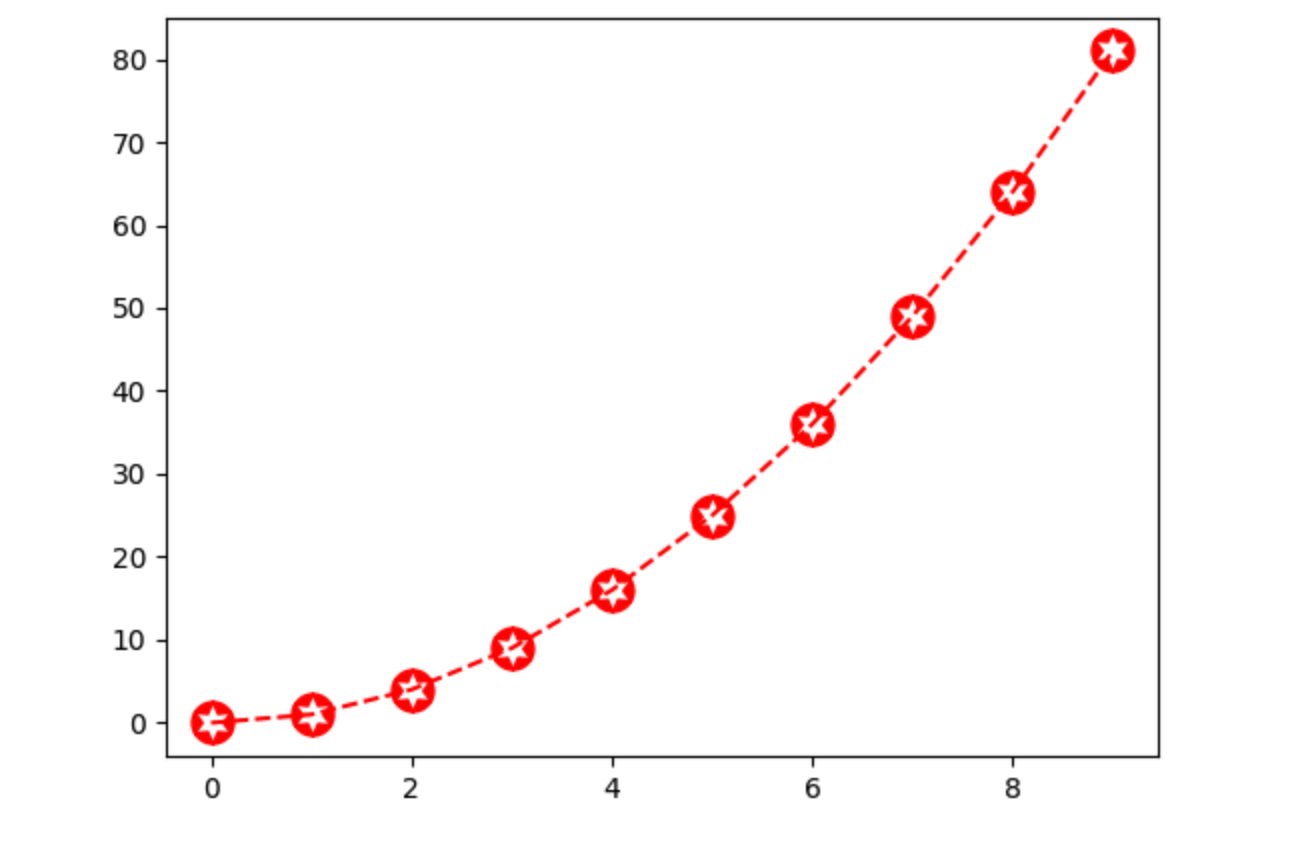

0.41025409151562525
0.22754379906715955


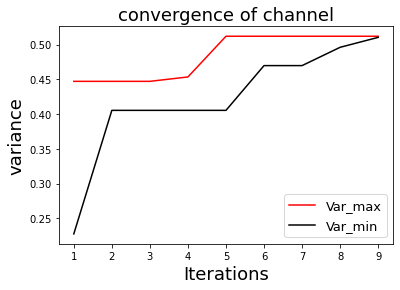

0.5119379980040902
0.510319050050095
9


In [57]:
e1 = search_weight(W1,W2,fw,N,1,0)
e2 = (1 / ( 1 + abs( -e1[0] / e1[1])),( -e1[0] / e1[1]) / ( 1 + abs( -e1[0] / e1[1])))
ff1 = []
ff2 = []
for i in range(0,groupnumber):
    ff1.append(e1[0]*Y3[groupnumber*(count-1)+i] + e1[1]*Y4[groupnumber*(count-1)+i])
    ff2.append(e2[0]*Y3[groupnumber*(count-1)+i] + e2[1]*Y4[groupnumber*(count-1)+i])
f1 = np.var(ff1)
f2 = np.var(ff2)
#weight matrix
V11 = e1[0]*e1[0]*(f1**(-0.5)) + e2[0]*e2[0]*(f2**(-0.5))
V12 = e1[0]*e1[1]*(f1**(-0.5)) + e2[0]*e2[1]*(f2**(-0.5))
V21 = e1[0]*e1[1]*(f1**(-0.5)) + e2[0]*e2[1]*(f2**(-0.5))
V22 = e1[1]*e1[1]*(f1**(-0.5)) + e2[1]*e2[1]*(f2**(-0.5))
count2 = count

In [58]:
def copy(v11=V11,v12=V12,v21=V21,v22=V22):
    return v11,v12,v21,v22

Get the weight of first channel

0.7663316155630717
0.7145300472509484


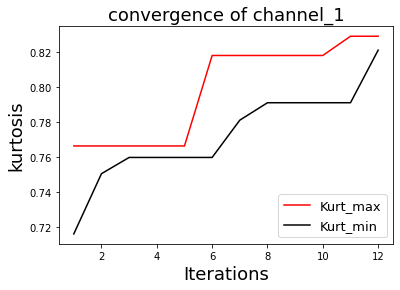

0.8291991235084248
0.8212306962076803
12


In [59]:
WW1 = []
WW2 = []
fww = []
for i in range(0,N):
    middle3 = (random.randint(0,200)-100) / 100
    middle4 = (random.randint(0,200)-100) / 100
    WW1.append(round(middle3 / (abs(middle3) + abs(middle4)),2))
    WW2.append(round(middle4 / (abs(middle3) + abs(middle4)),2))
    fww.append(f_vork(WW1[i],WW2[i],2,1))

WWW1 = []
WWW2 = []
fwww = []
for i in range(0,N):
    middle5 = (random.randint(0,200)-100) / 100
    middle6 = (random.randint(0,200)-100) / 100
    WWW1.append(round(middle5 / (abs(middle5) + abs(middle6)),2))
    WWW2.append(round(middle6 / (abs(middle5) + abs(middle6)),2))
    fwww.append(f_vork(WWW1[i],WWW2[i],2,1))

E1 = search_weight(WW1,WW2,fww,N,2,1)
#E2 = (1 / ( 1 + abs( E1[0] / E1[1])),( E1[0] / E1[1]) / ( 1 + abs( E1[0] / E1[1])))
#E11 = V11*E1[0] + V12*E1[1]
#E12 = V21*E1[0] + V22*E1[1]
#E21 = V11*E2[0] + V12*E2[1]
#E22 = V21*E2[0] + V22*E2[1]

Get the weight of second channel

0.7953679881143159
0.7125073674716202


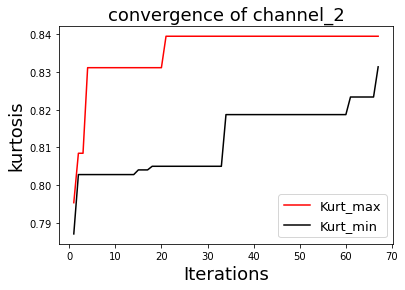

0.8394460831962882
0.8313462798937552
67


In [60]:
count = count2
E2 = search_weight(WWW1,WWW2,fwww,N,2,2)
E11 = round(0.8 + 0.2 *(V11*E1[0] + V12*E1[1])/(abs(V11*E1[0] + V12*E1[1])+abs(V21*E1[0] + V22*E1[1])),3)
E12 = round(-abs(0.2*(V21*E1[0] + V22*E1[1])/(abs(V11*E1[0] + V12*E1[1])+abs(V21*E1[0] + V22*E1[1]))),3)
E21 = round(-abs(0.2*(V11*E2[0] + V12*E2[1])/(abs(V11*E2[0] + V12*E2[1])+abs(V21*E2[0] + V22*E2[1]))),3)
E22 = round(0.8+0.2*(V21*E2[0] + V22*E2[1])/(abs(V11*E2[0] + V12*E2[1])+abs(V21*E2[0] + V22*E2[1])),3)

In [61]:
print(count)
print(E11)
print(E12)
print(E21)
print(E22)

337
0.746
-0.146
-0.173
0.827


In [62]:
Op1 = []
Op2 = []
Op1abs = []
Op2abs = []
for i in range(0,groupnumber):
    Op1.append(E11*Y3[groupnumber*(count-1)+i]+E12*Y4[groupnumber*(count-1)+i])
    Op2.append(E21*Y3[groupnumber*(count-1)+i]+E22*Y4[groupnumber*(count-1)+i])
    Op1abs.append(abs(Op1[i]))
    Op2abs.append(abs(Op2[i]))

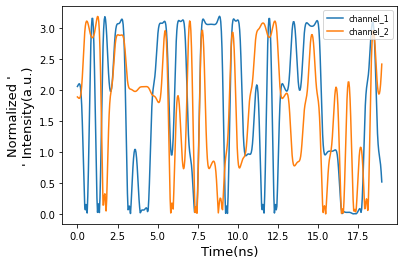

In [63]:
x = np.linspace(0,190,5000)
Y3test=[]
Y4test=[]
for i in range(0,5000):
    Y3test.append((a+0.005*math.sin(xx[i]*math.pi/200000))*y1[i]+(b+0.005*math.cos(xx[i]*math.pi/200000))*y2[i])
    Y4test.append((c-0.005*math.cos(xx[i]*math.pi/200000))*y1[i]+(d-0.005*math.sin(xx[i]*math.pi/200000))*y2[i])


Op1test = []
Op2test = []
Op1_abs_test = []
Op2_abs_test = []
for i in range(0,5000):
    Op1test.append(E11*Y3test[i]+E12*Y4test[i])
    Op2test.append(E21*Y3test[i]+E22*Y4test[i])
    Op1_abs_test.append(abs(Op1test[i]))
    Op2_abs_test.append(abs(Op2test[i]))
Op11test = []
Op22test = []
for i in range(0,5000):
    Op11test.append(Op1_abs_test[i]/max(Op1_abs_test)*3.2)
    Op22test.append(Op2_abs_test[i]/max(Op2_abs_test)*3.2)
plt.plot(x[:500],Op11test[:500])
#plt.plot(list(np.linspace(1,500,500)),y1[:500])
plt.plot(x[:500],Op22test[:500])
plt.xlabel("Time(ns)",fontsize=13)
plt.ylabel("Normalized '\n' Intensity(a.u.)",fontsize=13)
plt.legend(['channel_1','channel_2'],fontsize=8,loc=1)
#plt.plot(list(np.linspace(1,500,500)),y2[:500])
plt.show()

result: waveform

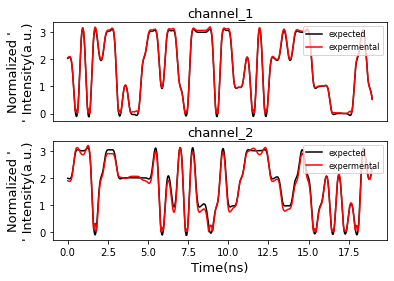

In [64]:



plt.subplot(2,1,1)
plt.plot(x[:500],y1[:500],'k')
#plt.plot(x[:500],Y3test[:500],'r')
plt.plot(x[:500],Op11test[:500],'r')
plt.ylabel("Normalized '\n' Intensity(a.u.)",fontsize=13)
plt.title('channel_1',fontsize=13)
plt.xticks([])

plt.legend(['expected','expermental'],fontsize=8,loc=1)


plt.subplot(2,1,2)
plt.plot(x[:500],y2[:500],'k')
#plt.plot(x[:500],Y4test[:500],'k')
plt.plot(x[:500],Op22test[:500],'r')
plt.xlabel("Time(ns)",fontsize=13)
plt.ylabel("Normalized '\n' Intensity(a.u.)",fontsize=13)
plt.title('channel_2',fontsize=13)


plt.legend(['expected','expermental'],fontsize=8,loc=1)

plt.show()

result: eye diagram

<span style="color:red">
comments (crh:) any reason why CH2 is worse? </span>

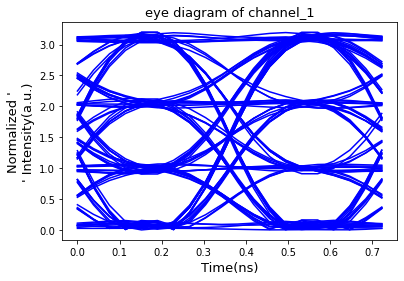

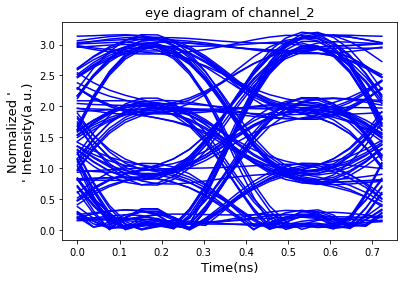

In [65]:
for i in range(100):
    y=[]
    for j in range(20):
        y.append(Op11test[(i+10)*20+j])
    plt.plot(x[:20],y,'b')
plt.xlabel("Time(ns)",fontsize=13)
plt.ylabel("Normalized '\n' Intensity(a.u.)",fontsize=13)
plt.title('eye diagram of channel_1',fontsize=13)
plt.show()

for i in range(100):
    y=[]
    for j in range(20):
        y.append(Op22test[(i+10)*20+j])
    plt.plot(x[:20],y,'b')
plt.xlabel("Time(ns)",fontsize=13)
plt.ylabel("Normalized '\n' Intensity(a.u.)",fontsize=13)
plt.title('eye diagram of channel_2',fontsize=13)
plt.show()

In [ ]:
<span style="color:red">
comments (crh:) can you plot the eye diagrams of the mixed signals before BSS? It should be a </span>